# Skin Lesion Classification - Data Exploration
## HAM10000 Dataset Analysis

This notebook performs exploratory data analysis on the HAM10000 (Human Against Machine with 10000 training images) dataset for skin lesion classification.

**Dataset:** 10,015 dermatoscopic images of pigmented skin lesions

**Classes (7):**
- akiec: Actinic keratoses and intraepithelial carcinoma
- bcc: Basal cell carcinoma
- bkl: Benign keratosis-like lesions
- df: Dermatofibroma
- mel: Melanoma
- nv: Melanocytic nevi
- vasc: Vascular lesions

In [1]:
import os
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

 # Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

 # Create directories
os.makedirs('../deep_learning/data', exist_ok=True)
os.makedirs('../deep_learning/models', exist_ok=True)
os.makedirs('../deep_learning/results', exist_ok=True)

# print("Environment setup complete!")
import sys
sys.path.append("..")   # go one level up to deep_learning


In [2]:
# Download the dataset
#!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p ../deep_learning/data/ --force
#!unzip -oq ../data/skin-cancer-mnist-ham10000.zip -d ../deep_learning/data/ham10000/
#print("Dataset download complete!")

from pathlib import Path
import os

# Current notebook folder
NOTEBOOK_DIR = Path(os.getcwd())

# Project root = parent of notebooks
root_dir = NOTEBOOK_DIR.parent
data_dir = root_dir / 'data' / 'ham10000'


In [3]:
# Load metadata
# The dataset comes in two CSV files that need to be concatenated
df = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
print(f"Total samples: {len(df)}")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
display(df.head())

Total samples: 10015

Dataset shape: (10015, 7)

First few rows:


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

## 2. Dataset Overview

In [4]:
# Column information
print("Column Information:")
print("="*50)
df.info()

print("\n" + "="*50)
print("Missing Values:")
print("="*50)
print(df.isnull().sum())

print("\n" + "="*50)
print("Statistical Summary:")
print("="*50)
display(df.describe())

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB

Missing Values:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Statistical Summary:


age
count  9958.000000
mean     51.863828
std      16.968614
min       0.000000
25%      40.000000
50%      50.000000
75%      65.000000
max      85.000000

## 3. Class Distribution Analysis

Understanding class imbalance is crucial for model training strategy.

In [5]:
# Class distribution
class_counts = df['dx'].value_counts()
print("Class Distribution:")
print("="*50)
for cls, count in class_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{cls:6s}: {count:5d} samples ({percentage:5.2f}%)")

print(f"\nImbalance Ratio: {class_counts.max() / class_counts.min():.2f}:1")

Class Distribution:
nv    :  6705 samples (66.95%)
mel   :  1113 samples (11.11%)
bkl   :  1099 samples (10.97%)
bcc   :   514 samples ( 5.13%)
akiec :   327 samples ( 3.27%)
vasc  :   142 samples ( 1.42%)
df    :   115 samples ( 1.15%)

Imbalance Ratio: 58.30:1


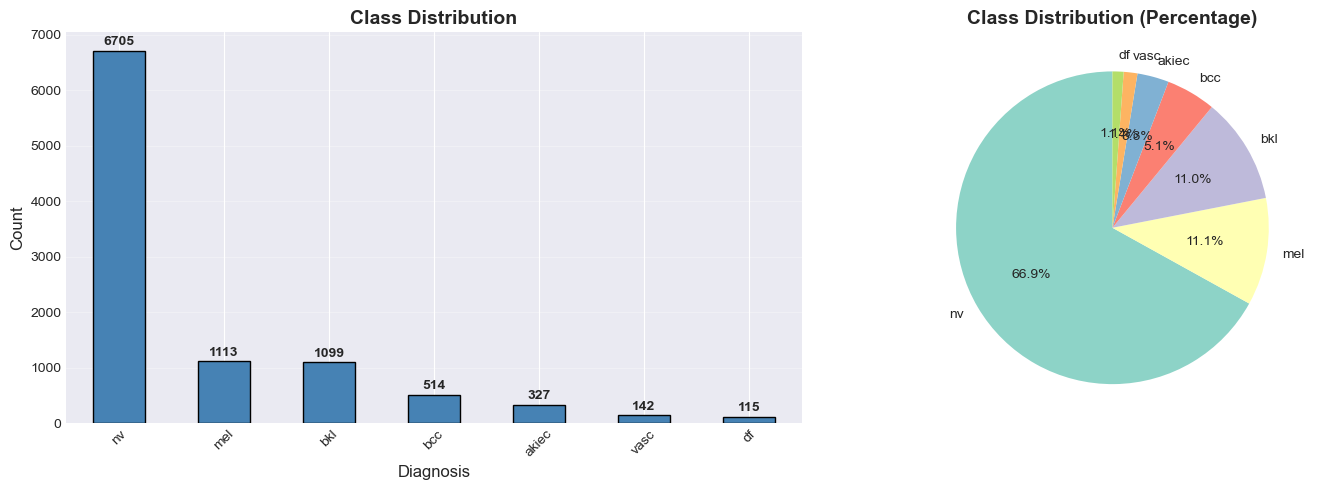


 Key Observation: Severe class imbalance detected!
This will require special handling during training (weighted loss, oversampling, etc.)


In [6]:
# Visualization of class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Diagnosis', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Pie chart
colors = plt.cm.Set3(range(len(class_counts)))
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 10})
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Key Observation: Severe class imbalance detected!")
print("This will require special handling during training (weighted loss, oversampling, etc.)")

## 4. Additional Metadata Analysis

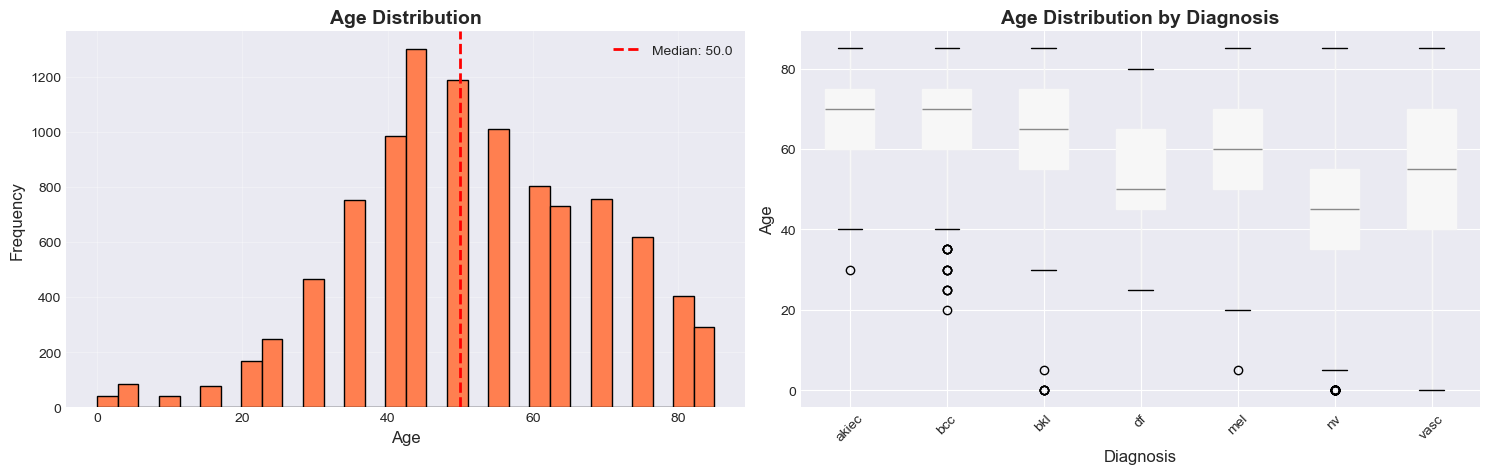

Age Statistics:
Mean: 51.9 years
Median: 50.0 years
Range: 0 - 85 years
Missing values: 57 (0.6%)


In [7]:
# Age distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Age histogram
df['age'].dropna().hist(bins=30, ax=axes[0], color='coral', edgecolor='black')
axes[0].set_title('Age Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Age', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].axvline(df['age'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df["age"].median():.1f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Age by diagnosis
df.boxplot(column='age', by='dx', ax=axes[1], patch_artist=True)
axes[1].set_title('Age Distribution by Diagnosis', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Diagnosis', fontsize=12)
axes[1].set_ylabel('Age', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

print(f"Age Statistics:")
print(f"Mean: {df['age'].mean():.1f} years")
print(f"Median: {df['age'].median():.1f} years")
print(f"Range: {df['age'].min():.0f} - {df['age'].max():.0f} years")
print(f"Missing values: {df['age'].isnull().sum()} ({df['age'].isnull().sum()/len(df)*100:.1f}%)")

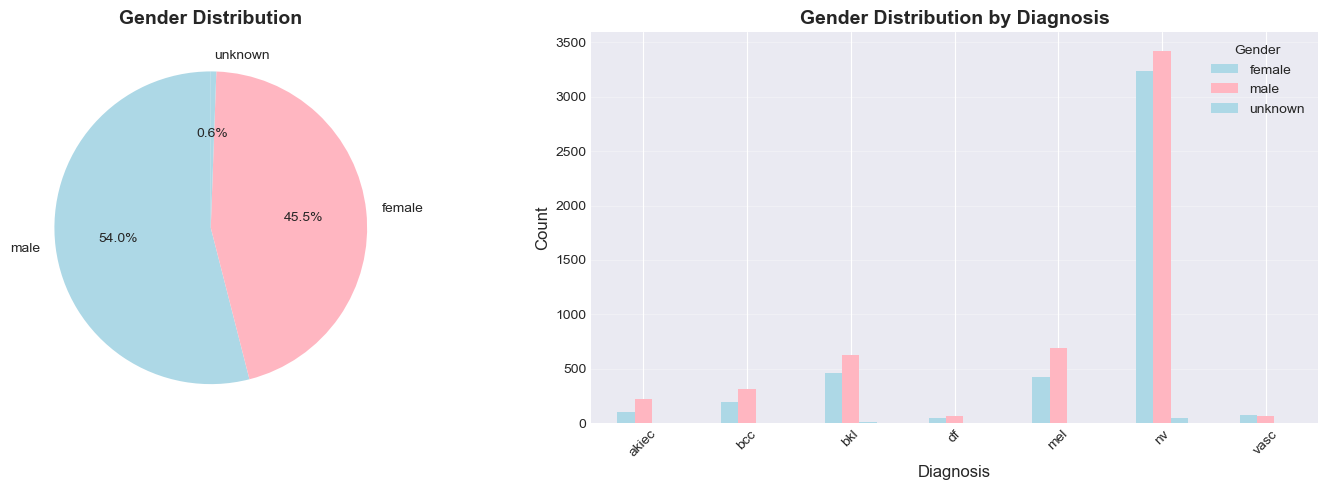


Gender Distribution:
sex
male       5406
female     4552
unknown      57
Name: count, dtype: int64

Missing values: 0


In [8]:
# Gender distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall gender distribution
gender_counts = df['sex'].value_counts()
axes[0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
            startangle=90, colors=['lightblue', 'lightpink'])
axes[0].set_title('Gender Distribution', fontsize=14, fontweight='bold')

# Gender by diagnosis
gender_dx = pd.crosstab(df['dx'], df['sex'])
gender_dx.plot(kind='bar', stacked=False, ax=axes[1], color=['lightblue', 'lightpink'])
axes[1].set_title('Gender Distribution by Diagnosis', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Diagnosis', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Gender')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nGender Distribution:")
print(gender_counts)
print(f"\nMissing values: {df['sex'].isnull().sum()}")

Lesion Localization Distribution:
localization
back               2192
lower extremity    2077
trunk              1404
upper extremity    1118
abdomen            1022
face                745
chest               407
foot                319
unknown             234
neck                168
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: count, dtype: int64


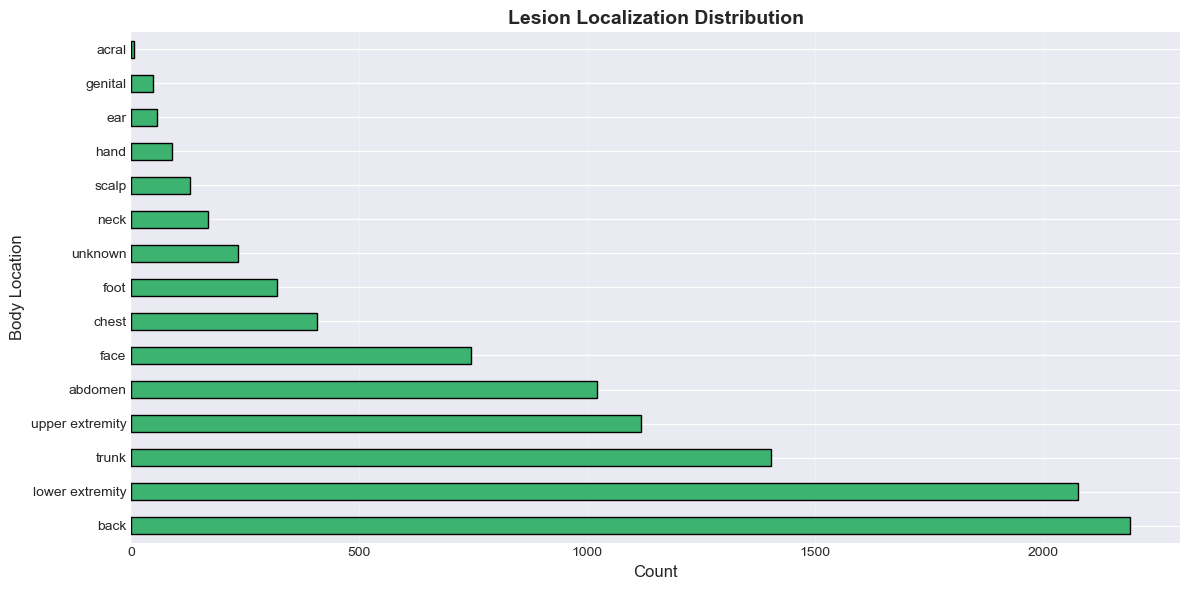

In [9]:
# Localization analysis
print("Lesion Localization Distribution:")
print("="*50)
localization_counts = df['localization'].value_counts()
print(localization_counts)

plt.figure(figsize=(12, 6))
localization_counts.plot(kind='barh', color='mediumseagreen', edgecolor='black')
plt.title('Lesion Localization Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Body Location', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Image Analysis

Let's examine the actual images and their properties.

In [10]:
# Function to get image path
def get_image_path(image_id):
    # Images are split into two folders
    path1 = os.path.join(data_dir, 'HAM10000_images_part_1', f'{image_id}.jpg')
    path2 = os.path.join(data_dir, 'HAM10000_images_part_2', f'{image_id}.jpg')
    
    if os.path.exists(path1):
        return path1
    elif os.path.exists(path2):
        return path2
    else:
        return None

# Sample image to check dimensions
sample_img_path = get_image_path(df.iloc[100]['image_id'])
if sample_img_path:
    sample_img = Image.open(sample_img_path)
    print(f"Sample image shape: {sample_img.size}")
    print(f"Image mode: {sample_img.mode}")


Sample image shape: (600, 450)
Image mode: RGB


In [11]:
# 2. ANALYZE IMAGE DIMENSIONS
print("🔍 Starting analysis of image dimensions...")

widths = []
heights = []
aspect_ratios = []

# Sample 1000 images for efficiency
sample_df = df.sample(n=min(1000, len(df)), random_state=42)

for img_id in sample_df['image_id']:
    img_path = get_image_path(img_id)
    if img_path:
        try:
            # Using 'with' ensures the file is closed immediately after reading size
            with Image.open(img_path) as img:
                w, h = img.size
                widths.append(w)
                heights.append(h)
                aspect_ratios.append(w/h)
        except Exception as e:
            print(f"Skipping {img_id}: {e}")
            continue

# 3. VERIFY DATA WAS COLLECTED
if len(widths) == 0:
    print("\n ERROR: No images were found!")
    print(f"Looked in: {data_dir}")
    print("Please check if the folder names match: 'HAM10000_images_part_1' and 'part_2'")
else:
    print(f" Analyzed {len(widths)} images successfully.\n")
    print(f"Width  - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.1f}")
    print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.1f}")
    print(f"Aspect Ratio Mean: {np.mean(aspect_ratios):.2f}")

🔍 Starting analysis of image dimensions...
 Analyzed 1000 images successfully.

Width  - Min: 600, Max: 600, Mean: 600.0
Height - Min: 450, Max: 450, Mean: 450.0
Aspect Ratio Mean: 1.33


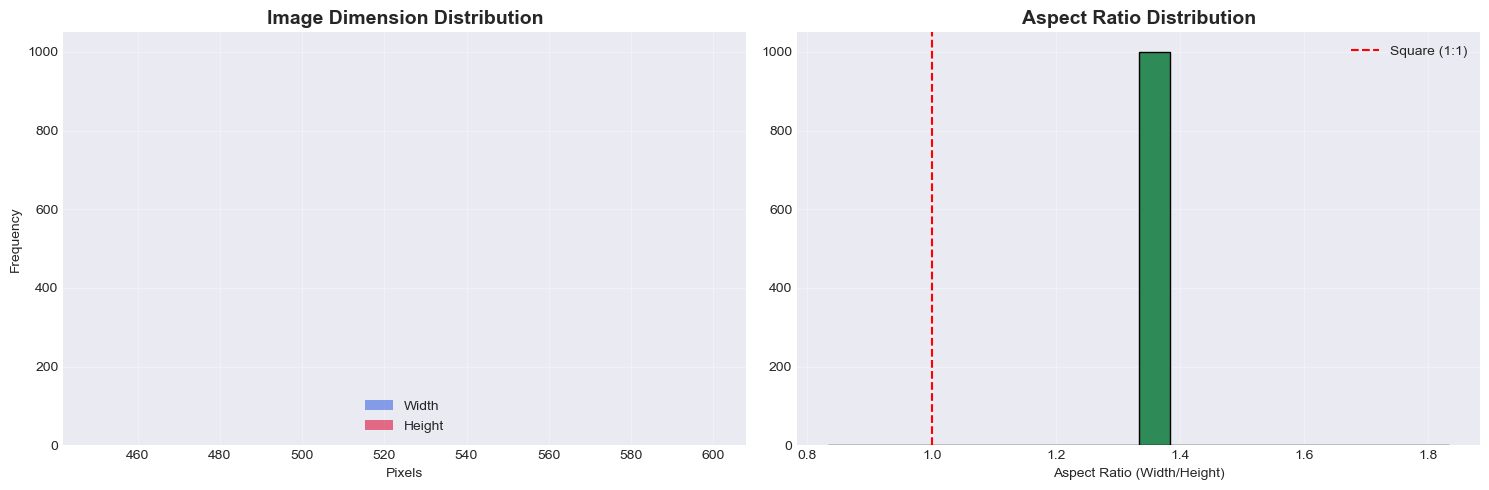

In [12]:
    # 4. VISUALIZATION
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Dimension distribution
    axes[0].hist(widths, bins=20, alpha=0.6, label='Width', color='royalblue')
    axes[0].hist(heights, bins=20, alpha=0.6, label='Height', color='crimson')
    axes[0].set_title('Image Dimension Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Pixels')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Aspect ratio distribution
    axes[1].hist(aspect_ratios, bins=20, color='seagreen', edgecolor='black')
    axes[1].set_title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Aspect Ratio (Width/Height)')
    axes[1].axvline(1.0, color='red', linestyle='--', label='Square (1:1)')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()

## 6. Sample Images Visualization

Let's visualize sample images from each class.

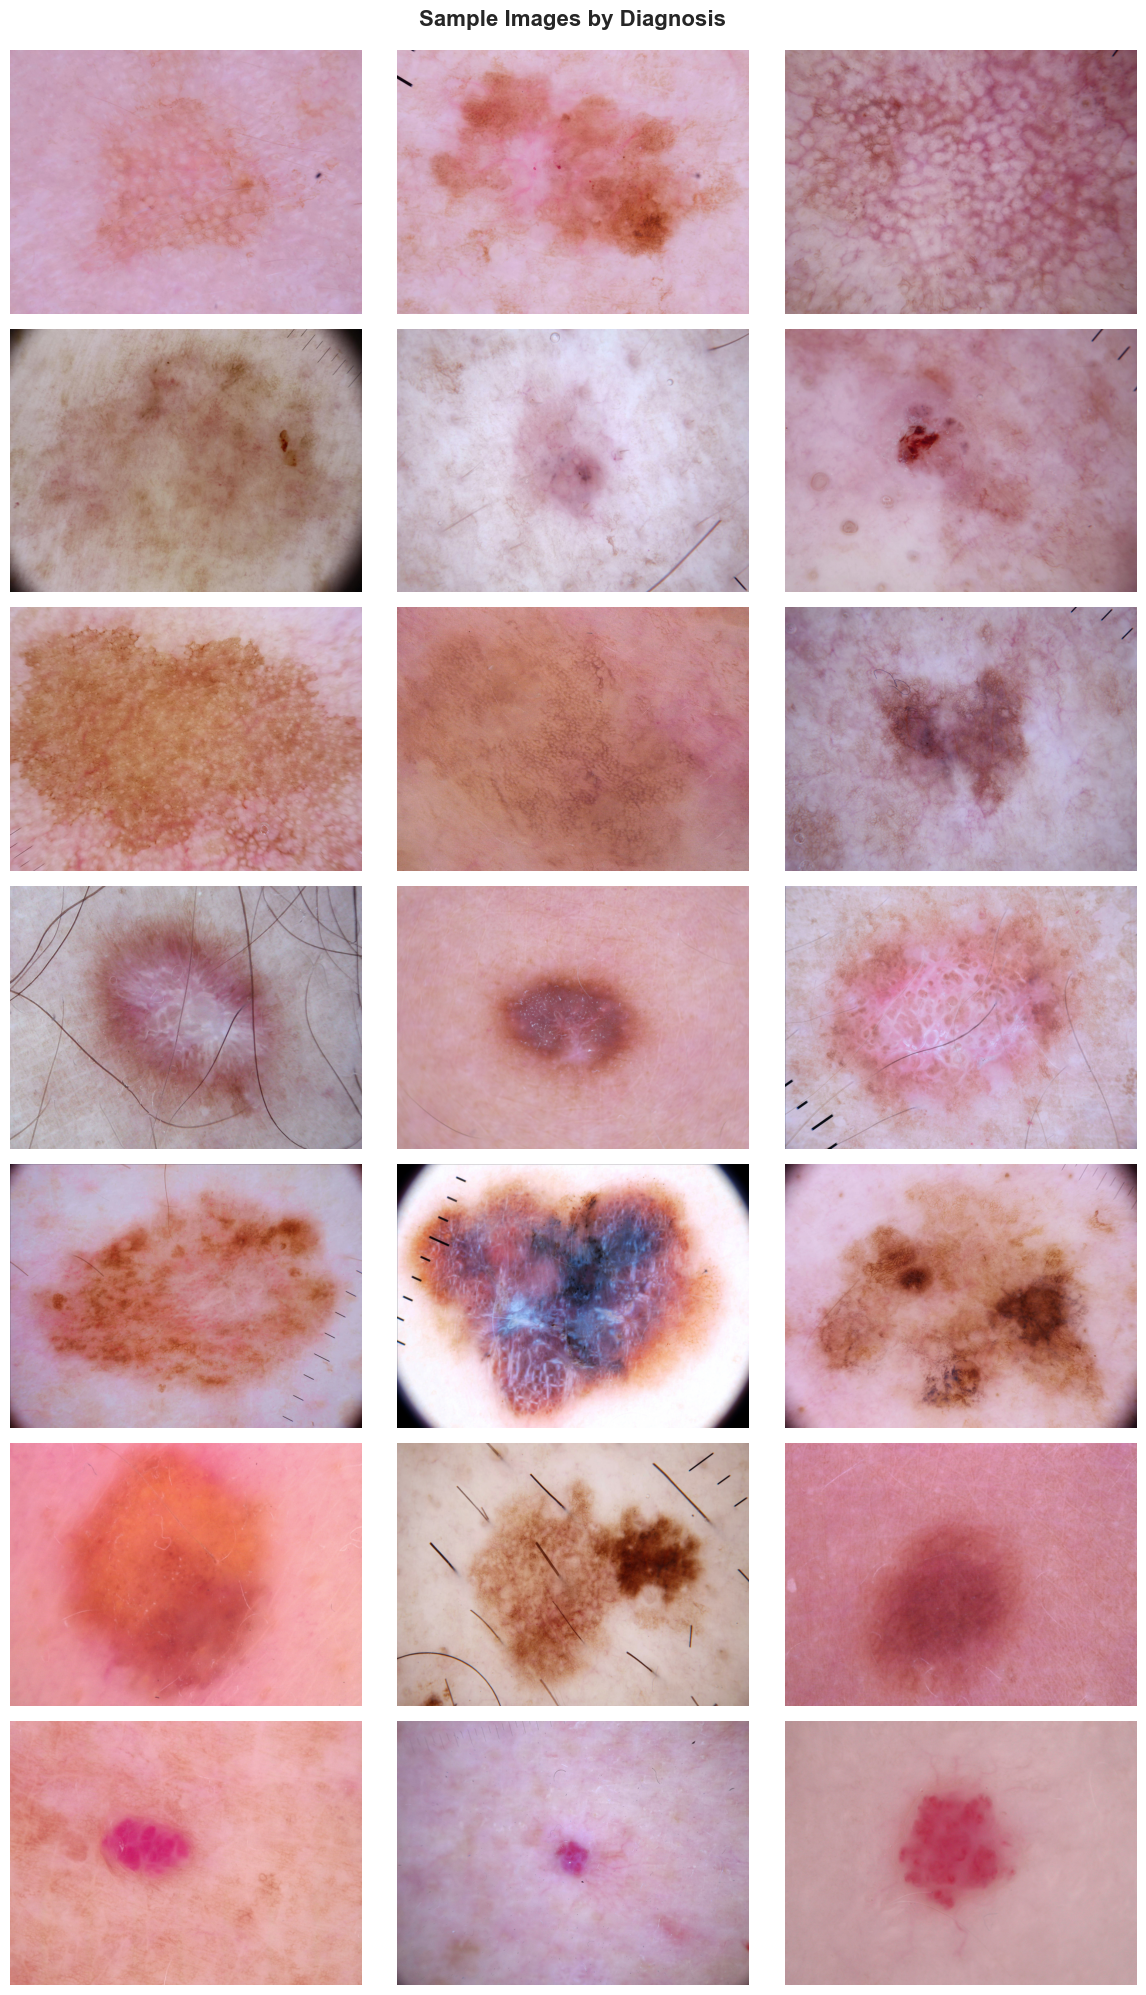

In [13]:
# Class label mapping for better visualization
class_names = {
    'akiec': 'Actinic Keratoses',
    'bcc': 'Basal Cell Carcinoma',
    'bkl': 'Benign Keratosis',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic Nevi',
    'vasc': 'Vascular Lesions'
}

# Display 3 samples from each class
fig, axes = plt.subplots(7, 3, figsize=(12, 20))
fig.suptitle('Sample Images by Diagnosis', fontsize=16, fontweight='bold', y=0.995)

for idx, (dx_code, dx_name) in enumerate(class_names.items()):
    class_samples = df[df['dx'] == dx_code].sample(n=3, random_state=42)
    
    for col, (_, row) in enumerate(class_samples.iterrows()):
        img_path = get_image_path(row['image_id'])
        if img_path:
            img = Image.open(img_path)
            axes[idx, col].imshow(img)
            axes[idx, col].axis('off')
            
            if col == 0:
                axes[idx, col].set_ylabel(f"{dx_code.upper()}\n{dx_name}", 
                                         fontsize=10, fontweight='bold', rotation=0, 
                                         ha='right', va='center')

plt.tight_layout()
plt.show()

## 7. Duplicate Images Analysis

The dataset may contain duplicate images of the same lesion taken at different times.

Total unique lesions: 7470
Total images: 10015
Lesions with multiple images: 1956

Top 10 lesions with most images:
lesion_id
HAM_0003789    6
HAM_0000835    6
HAM_0005263    6
HAM_0001863    6
HAM_0007427    5
HAM_0007343    5
HAM_0000893    5
HAM_0007367    5
HAM_0002364    5
HAM_0003602    4
Name: count, dtype: int64


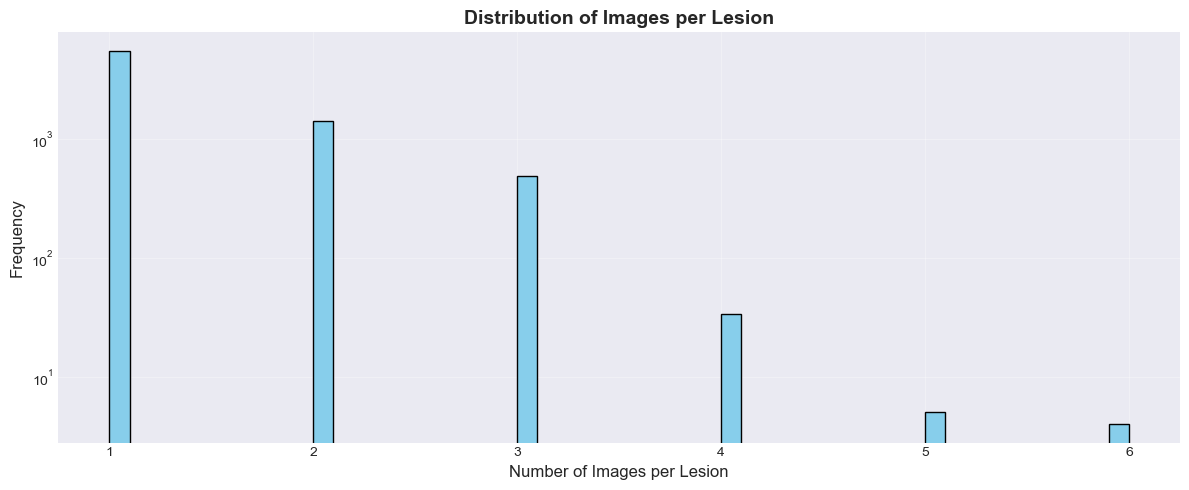


 Important: We need to ensure lesions from the same patient don't appear in both train and test sets!


In [14]:
# Check for duplicate lesion_ids
duplicate_lesions = df['lesion_id'].value_counts()
duplicates = duplicate_lesions[duplicate_lesions > 1]

print(f"Total unique lesions: {df['lesion_id'].nunique()}")
print(f"Total images: {len(df)}")
print(f"Lesions with multiple images: {len(duplicates)}")
print(f"\nTop 10 lesions with most images:")
print(duplicates.head(10))

# Visualize
plt.figure(figsize=(12, 5))
plt.hist(duplicate_lesions.values, bins=50, edgecolor='black', color='skyblue')
plt.title('Distribution of Images per Lesion', fontsize=14, fontweight='bold')
plt.xlabel('Number of Images per Lesion', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.yscale('log')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Important: We need to ensure lesions from the same patient don't appear in both train and test sets!")